In [46]:
#basic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import shap
from statistics import mean, stdev
import seaborn as sns
from statannot import add_stat_annotation
from matplotlib.patches import Patch
from dna_features_viewer import GraphicFeature, GraphicRecord

In [47]:
#dataframe imports

partial_sec_incorrect = pd.read_csv('austin_db/partial_sec_incorrect.csv')
model_proteins = pd.read_csv('austin_db/model_proteins_final.csv')
model_peptides = pd.read_csv('austin_db/model_peptides_final.csv')
only_kathi_features = pd.read_csv('all_proteins_kathi.csv')

proteinfeatures = pd.read_csv('austin_db/proteinfeatures.csv')

In [69]:
model_proteins = model_proteins.rename(columns={'Protein': 'Uniprot'})

In [48]:
model_peptides['coverage'] = model_peptides['Sequence_Length'] / model_peptides['Protein_Length']

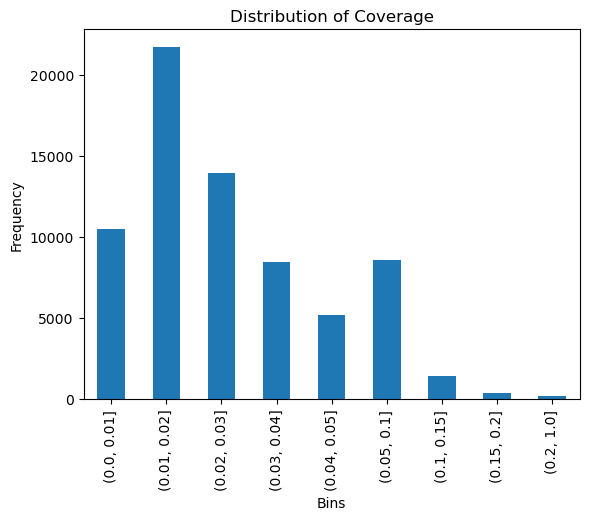

In [49]:
# making a coverage histogram
bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 1.0]

# Cut the data into bins and count the occurrences in each bin
bin_counts = pd.cut(model_peptides['coverage'], bins=bins).value_counts().sort_index()

# Plot the histogram
bin_counts.plot(kind='bar')

# Add labels and title
plt.title('Distribution of Coverage')
plt.xlabel('Bins')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [50]:
#these are the 124 incorrectly classified partially secreted proteins that come from Austin's 3 class RF with reduced features.
partial_sec_incorrect.columns.to_list()

['Unnamed: 0',
 'Length',
 'Molecular weight',
 'A_y',
 'C_y',
 'D_y',
 'E_y',
 'F_y',
 'G_y',
 'H_y',
 'I_y',
 'K_y',
 'L_y',
 'M_y',
 'N_y',
 'P_y',
 'Q_y',
 'R_y',
 'S_y',
 'T_y',
 'V_y',
 'W_y',
 'Y_y',
 'Isoelectric point',
 'Instability index',
 'Disorder_NSP',
 'Helix_NSP',
 'Coil_NSP',
 'Sheet_NSP',
 'Signal peptide',
 'Extracellular_y',
 'Ectodomain_shedding',
 'EV',
 'Uniprot',
 'Actual',
 'Predicted',
 'Correct']

In [51]:
partial_sec_incorrect = partial_sec_incorrect.drop(['Unnamed: 0','A_y','C_y','D_y','E_y','F_y','G_y','H_y','I_y','K_y','L_y','M_y','N_y','P_y','Q_y','R_y','S_y','T_y','V_y','W_y','Y_y','Isoelectric point','Instability index','Disorder_NSP','Helix_NSP','Coil_NSP','Sheet_NSP'], axis=1)

In [52]:
partial_sec_incorrect = partial_sec_incorrect.drop(['Length'], axis=1)

In [53]:
model_peptides = model_peptides.rename(columns={'Protein': 'Uniprot'})

In [54]:
merged_peptide = pd.merge(model_peptides, partial_sec_incorrect, on='Uniprot', how='right')

In [ ]:
#merged_peptide.to_csv('merged_peptide.csv')

In [55]:
partial_sec_incorrect.columns.to_list()

['Molecular weight',
 'Signal peptide',
 'Extracellular_y',
 'Ectodomain_shedding',
 'EV',
 'Uniprot',
 'Actual',
 'Predicted',
 'Correct']

P28074


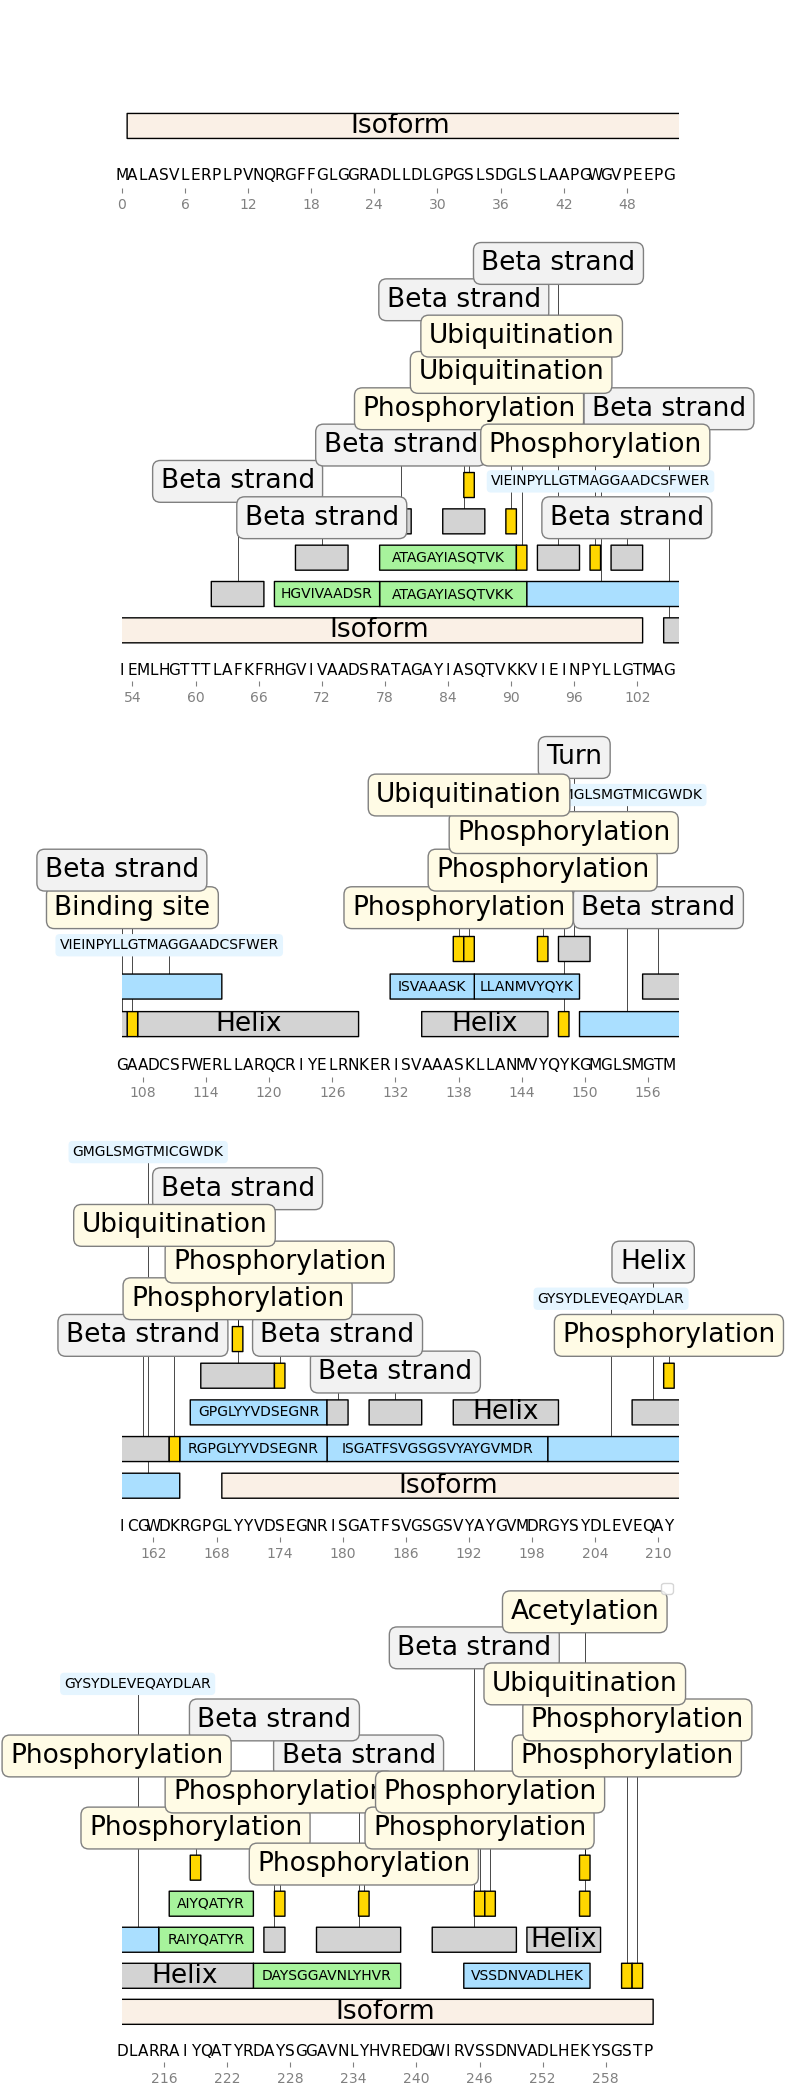

In [32]:
#This is Jaime's Visualization Code. Gonna look at this now.


featureslistPTM = ['Signal','Glycosylation','Phosphorylation','Acetylation','Methylation','Ubiquitination','Succinylation','Hydroxylation',
                'Palmitoylation','Binding site']
featureslistDomain = ['Domain','Signal','Disordered','Disulfide bond','Helix','Beta strand','Turn','Basic and acidic residues',
                'Polar residues','Coiled coil','Cytoplasmic','Lumenal','Extracellular','Transit peptide','Transmembrane','Alternative sequence','isoform']

# improve visibility of PTM's

legend_elements = [Patch(facecolor='forestgreen', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#51CAFE', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]

sample = partial_sec_incorrect['Uniprot'].unique()

for protein in ['P28074']:   
    legend_elements = []
    ptms = proteinfeatures[proteinfeatures['Protein']==protein]
    print(protein)
    temp = model_peptides[model_peptides['Uniprot']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['Region_Classification'] == False or t[1]['CSF'] == 'Brain + CSF':
            c = "#A7F39C"
        else: c = "#AADFFF"
        featureslist.append( GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=18,box_linewidth=0,fontdict={'fontsize': 10}))

    # add domains to features
    for n,s in proteinfeatures[proteinfeatures['Protein']==protein].iterrows():
        if 'isoform' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="linen", label="Isoform",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if 'helical' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label="Helical",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistPTM:
            featureslist.append(GraphicFeature(start=int(s['Start']), end=int(s['End']+1),strand=0, color="#ffd700", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistDomain:
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_thickness=1,box_linewidth=1,fontdict={'fontsize': 19}))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')

    ax1, _ = record.plot_on_multiple_lines(n_lines=5,annotate_inline=True,level_offset=0.4,draw_line=False,plot_sequence=True)
    # fontdict = {'weight': 'bold'}
    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('misclassified_P28074', bbox_inches='tight')
    plt.show()


In [56]:
#just making a smaller df for viewing. 
only_sec_peptides = merged_peptide[merged_peptide['CSF'] == 'Brain + CSF']

In [57]:
only_sec_peptides

,Peptide_Sequence,Sequence_Length,Uniprot,Brain,CSF,Author,Detectability,Detection_Probability,Protein_Sequence,Protein_Length,...,Alternative sequence,coverage,Molecular weight,Signal peptide,Extracellular_y,Ectodomain_shedding,EV,Actual,Predicted,Correct
0,AIYQATYR,8.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.953721,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.030418,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
1,ATAGAYIASQTVK,13.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.848275,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.049430,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
2,ATAGAYIASQTVKK,14.0,P28074,True,Brain + CSF,"Faigle, Rydbirk",1.0,0.877420,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.053232,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
3,DAYSGGAVNLYHVR,14.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.561403,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.053232,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
7,HGVIVAADSR,10.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.882464,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.038023,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,SSAGNAPCSPCPAR,14.0,O15197,True,Brain + CSF,"Faigle, Duong",1.0,0.637020,MATEGAAQLGNRVAGMVCSLWVLLLVSSVLALEEVLLDTTGETSEI...,1021.0,...,0,0.013712,110699.0031,1,0,0,1,Partially_Secreted,Not_Secreted,N
2426,TFEACHVAGAPPGTGQDNWLQTHFVER,27.0,O15197,True,Brain + CSF,"Rydbirk, Duong",1.0,0.922671,MATEGAAQLGNRVAGMVCSLWVLLLVSSVLALEEVLLDTTGETSEI...,1021.0,...,1,0.026445,110699.0031,1,0,0,1,Partially_Secreted,Not_Secreted,N
2428,AEETEQMIEK,10.0,Q9HCJ6,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.802465,MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVV...,419.0,...,0,0.023866,45898.9152,0,0,0,0,Partially_Secreted,Not_Secreted,N
2434,GYEIGDR,7.0,Q9HCJ6,True,Brain + CSF,"Rydbirk, Duong",1.0,0.775801,MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVV...,419.0,...,0,0.016706,45898.9152,0,0,0,0,Partially_Secreted,Not_Secreted,N


In [58]:
merged_peptide

,Peptide_Sequence,Sequence_Length,Uniprot,Brain,CSF,Author,Detectability,Detection_Probability,Protein_Sequence,Protein_Length,...,Alternative sequence,coverage,Molecular weight,Signal peptide,Extracellular_y,Ectodomain_shedding,EV,Actual,Predicted,Correct
0,AIYQATYR,8.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.953721,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.030418,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
1,ATAGAYIASQTVK,13.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.848275,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.049430,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
2,ATAGAYIASQTVKK,14.0,P28074,True,Brain + CSF,"Faigle, Rydbirk",1.0,0.877420,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.053232,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
3,DAYSGGAVNLYHVR,14.0,P28074,True,Brain + CSF,"Faigle, Rydbirk, Duong",1.0,0.561403,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,1,0.053232,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
4,GMGLSMGTMICGWDK,15.0,P28074,True,Brain Only,"Rydbirk, Duong",1.0,0.973254,MALASVLERPLPVNQRGFFGLGGRADLLDLGPGSLSDGLSLAAPGW...,263.0,...,0,0.057034,28479.9474,0,0,0,1,Partially_Secreted,Not_Secreted,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,SFFSFAK,7.0,Q9HCJ6,True,Brain Only,"Faigle, Rydbirk, Duong",0.0,0.248717,MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVV...,419.0,...,0,0.016706,45898.9152,0,0,0,0,Partially_Secreted,Not_Secreted,N
2444,SWWQVEK,7.0,Q9HCJ6,True,Brain Only,"Rydbirk, Duong",1.0,0.915074,MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVV...,419.0,...,0,0.016706,45898.9152,0,0,0,0,Partially_Secreted,Not_Secreted,N
2445,TPLVPGFECSGIVEALGDSVK,21.0,Q9HCJ6,True,Brain Only,"Faigle, Rydbirk, Duong",0.0,0.456093,MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVV...,419.0,...,0,0.050119,45898.9152,0,0,0,0,Partially_Secreted,Not_Secreted,N
2446,TPTPLMANDSTETSEAGEEEEDHEGDSENK,30.0,Q9HCJ6,True,Brain Only,"Rydbirk, Duong",1.0,0.740410,MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVV...,419.0,...,0,0.071599,45898.9152,0,0,0,0,Partially_Secreted,Not_Secreted,N


In [59]:
# Grouped all the Unique Uniprot IDs and now doing some exploration on the peptide level for this small subset

misclassified_exploration = merged_peptide.groupby('Uniprot').agg(
    Num_Peptides_Sec_1=('CSF', lambda x: (x == 'Brain + CSF').sum()),
    Total_Num_Peptides=('Peptide_Sequence', 'count'),
    Total_Coverage=('Sequence_Length', lambda x: (x[merged_peptide['CSF'] == 'Brain + CSF'].sum()) / merged_peptide['Protein_Length'].iloc[0])
).reset_index()

print(result)

         Uniprot  Num_Peptides_Sec_1  Total_Num_Peptides  Total_Coverage  \
0     A0A096LPE2                   2                   2        0.015677   
1     A0A0B4J2A0                   0                   8        0.000000   
2     A0A0C4DH38                   0                   3        0.000000   
3         A0AVT1                   0                  48        0.000000   
4         A0FGR8                   1                  25        0.013201   
...          ...                 ...                 ...             ...   
5365      Q9Y6U3                   4                  22        0.037129   
5366      Q9Y6W5                   0                   8        0.000000   
5367      Q9Y6X4                   0                  20        0.000000   
5368      Q9Y6X5                   1                   7        0.007426   
5369      Q9Y6Y8                   0                  16        0.000000   

      Total_Sec_Percentage  Total_Sec_Pep_Perc  
0                 1.000000            

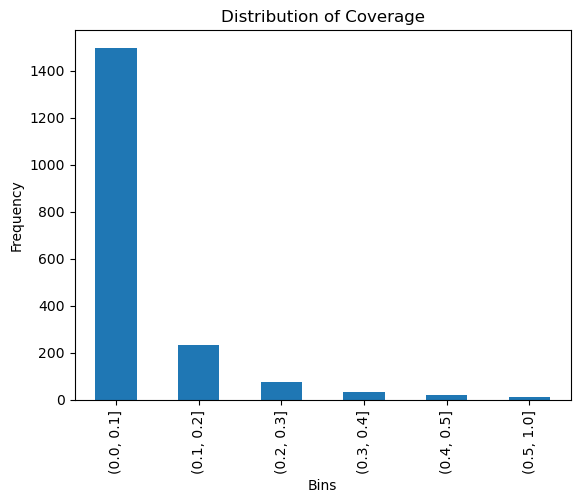

In [60]:
# making a coverage histogram
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]

# Cut the data into bins and count the occurrences in each bin
bin_counts = pd.cut(result['Total_Coverage'], bins=bins).value_counts().sort_index()

# Plot the histogram
bin_counts.plot(kind='bar')

# Add labels and title
plt.title('Distribution of Coverage')
plt.xlabel('Bins')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [61]:
#Ok this is pretty interesting - let's see what this looks like on the ENTIRE peptide dataset.

# Grouped all the Unique Uniprot IDs and now doing some exploration on the peptide level for this small subset

result = model_peptides.groupby('Uniprot').agg(
    Num_Peptides_Sec_1=('CSF', lambda x: (x == 'Brain + CSF').sum()),
    Total_Num_Peptides=('Peptide_Sequence', 'count'),
    Total_Coverage=('Sequence_Length', lambda x: (x[model_peptides['CSF'] == 'Brain + CSF'].sum()) / model_peptides['Protein_Length'].iloc[0])
).reset_index()

print(result)

         Uniprot  Num_Peptides_Sec_1  Total_Num_Peptides  Total_Coverage
0     A0A096LPE2                   2                   2        0.015677
1     A0A0B4J2A0                   0                   8        0.000000
2     A0A0C4DH38                   0                   3        0.000000
3         A0AVT1                   0                  48        0.000000
4         A0FGR8                   1                  25        0.013201
...          ...                 ...                 ...             ...
5365      Q9Y6U3                   4                  22        0.037129
5366      Q9Y6W5                   0                   8        0.000000
5367      Q9Y6X4                   0                  20        0.000000
5368      Q9Y6X5                   1                   7        0.007426
5369      Q9Y6Y8                   0                  16        0.000000

[5370 rows x 4 columns]


In [62]:
result['Total_Sec_Pep_Perc'] = result['Num_Peptides_Sec_1']/result['Total_Num_Peptides']

In [63]:
result

,Uniprot,Num_Peptides_Sec_1,Total_Num_Peptides,Total_Coverage,Total_Sec_Pep_Perc
0,A0A096LPE2,2,2,0.015677,1.000000
1,A0A0B4J2A0,0,8,0.000000,0.000000
2,A0A0C4DH38,0,3,0.000000,0.000000
3,A0AVT1,0,48,0.000000,0.000000
4,A0FGR8,1,25,0.013201,0.040000
...,...,...,...,...,...
5365,Q9Y6U3,4,22,0.037129,0.181818
5366,Q9Y6W5,0,8,0.000000,0.000000
5367,Q9Y6X4,0,20,0.000000,0.000000
5368,Q9Y6X5,1,7,0.007426,0.142857


In [70]:
all_proteins_with_sauce = pd.merge(model_proteins, result, on = 'Uniprot')

__Modified Visulaization Code for Different Proteins__

Q06828


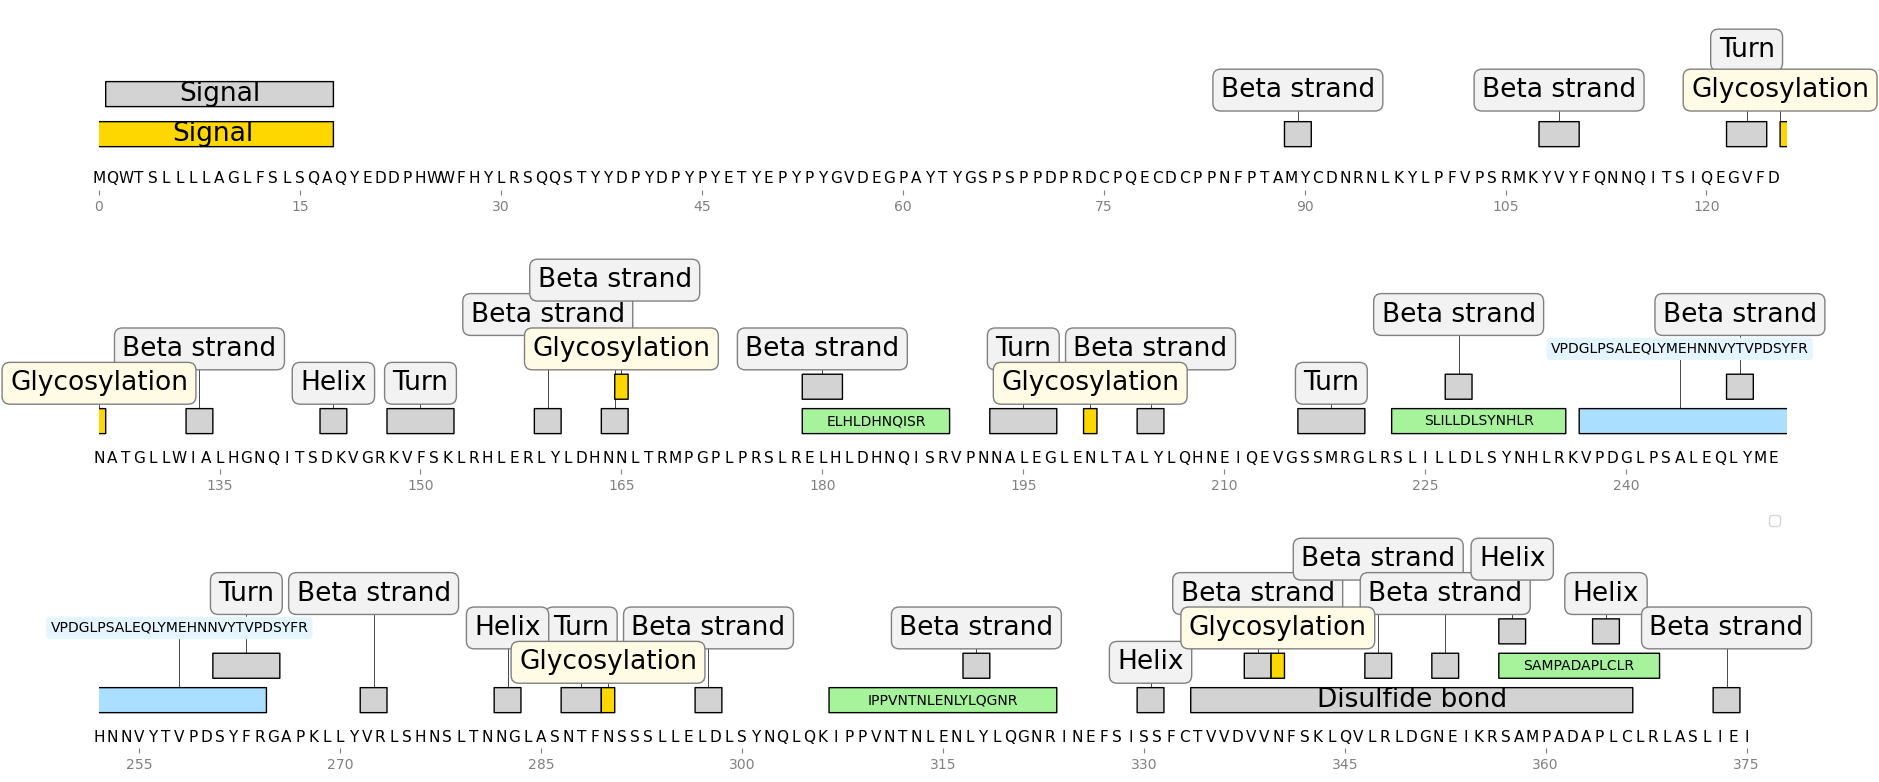

In [90]:
featureslistPTM = ['Signal','Glycosylation','Phosphorylation','Acetylation','Methylation','Ubiquitination','Succinylation','Hydroxylation',
                'Palmitoylation','Binding site']
featureslistDomain = ['Domain','Signal','Disordered','Disulfide bond','Helix','Beta strand','Turn','Basic and acidic residues',
                'Polar residues','Coiled coil','Cytoplasmic','Lumenal','Extracellular','Transit peptide','Transmembrane','Alternative sequence','isoform']

# improve visibility of PTM's

legend_elements = [Patch(facecolor='forestgreen', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#51CAFE', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]

sample = partial_sec_incorrect['Uniprot'].unique()

for protein in ['Q06828']:   
    legend_elements = []
    ptms = proteinfeatures[proteinfeatures['Protein']==protein]
    print(protein)
    temp = model_peptides[model_peptides['Uniprot']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['Region_Classification'] == False or t[1]['CSF'] == 'Brain + CSF':
            c = "#A7F39C"
        else: c = "#AADFFF"
        featureslist.append( GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=18,box_linewidth=0,fontdict={'fontsize': 10}))

    # add domains to features
    for n,s in proteinfeatures[proteinfeatures['Protein']==protein].iterrows():
        if 'isoform' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="linen", label="Isoform",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if 'helical' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label="Helical",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistPTM:
            featureslist.append(GraphicFeature(start=int(s['Start']), end=int(s['End']+1),strand=0, color="#ffd700", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistDomain:
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_thickness=1,box_linewidth=1,fontdict={'fontsize': 19}))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')

    ax1, _ = record.plot_on_multiple_lines(n_lines=3,annotate_inline=True,level_offset=0.4,draw_line=False,plot_sequence=True)

    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('final_figures/Q06828', bbox_inches='tight')
    plt.show()


In [ ]:
featureslistPTM = ['Signal','Glycosylation','Phosphorylation','Acetylation','Methylation','Ubiquitination','Succinylation','Hydroxylation',
                'Palmitoylation','Binding site']
featureslistDomain = ['Domain','Signal','Disordered','Disulfide bond','Helix','Beta strand','Turn','Basic and acidic residues',
                'Polar residues','Coiled coil','Cytoplasmic','Lumenal','Extracellular','Transit peptide','Transmembrane','Alternative sequence','isoform']

# improve visibility of PTM's

legend_elements = [Patch(facecolor='forestgreen', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#51CAFE', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]

sample = partial_sec_incorrect['Uniprot'].unique()

for protein in ['P14543']:   
    legend_elements = []
    ptms = proteinfeatures[proteinfeatures['Protein']==protein]
    print(protein)
    temp = model_peptides[model_peptides['Uniprot']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['Region_Classification'] == False or t[1]['CSF'] == 'Brain + CSF':
            c = "#A7F39C"
        else: c = "#AADFFF"
        featureslist.append( GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=18,box_linewidth=0,fontdict={'fontsize': 10}))

    # add domains to features
    for n,s in proteinfeatures[proteinfeatures['Protein']==protein].iterrows():
        if 'isoform' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="linen", label="Isoform",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if 'helical' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label="Helical",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistPTM:
            featureslist.append(GraphicFeature(start=int(s['Start']), end=int(s['End']+1),strand=0, color="#ffd700", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistDomain:
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_thickness=1,box_linewidth=1,fontdict={'fontsize': 19}))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')

    ax1, _ = record.plot_on_multiple_lines(n_lines=3,annotate_inline=True,level_offset=0.4,draw_line=False,plot_sequence=True)

    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('final_figures/P14543', bbox_inches='tight')
    plt.show()


In [ ]:
featureslistPTM = ['Signal','Glycosylation','Phosphorylation','Acetylation','Methylation','Ubiquitination','Succinylation','Hydroxylation',
                'Palmitoylation','Binding site']
featureslistDomain = ['Domain','Signal','Disordered','Disulfide bond','Helix','Beta strand','Turn','Basic and acidic residues',
                'Polar residues','Coiled coil','Cytoplasmic','Lumenal','Extracellular','Transit peptide','Transmembrane','Alternative sequence','isoform']

# improve visibility of PTM's

legend_elements = [Patch(facecolor='forestgreen', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#51CAFE', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]

sample = partial_sec_incorrect['Uniprot'].unique()

for protein in ['P29323']:   
    legend_elements = []
    ptms = proteinfeatures[proteinfeatures['Protein']==protein]
    print(protein)
    temp = model_peptides[model_peptides['Uniprot']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['Region_Classification'] == False or t[1]['CSF'] == 'Brain + CSF':
            c = "#A7F39C"
        else: c = "#AADFFF"
        featureslist.append( GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=18,box_linewidth=0,fontdict={'fontsize': 10}))

    # add domains to features
    for n,s in proteinfeatures[proteinfeatures['Protein']==protein].iterrows():
        if 'isoform' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="linen", label="Isoform",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if 'helical' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label="Helical",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistPTM:
            featureslist.append(GraphicFeature(start=int(s['Start']), end=int(s['End']+1),strand=0, color="#ffd700", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistDomain:
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_thickness=1,box_linewidth=1,fontdict={'fontsize': 19}))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')

    ax1, _ = record.plot_on_multiple_lines(n_lines=3,annotate_inline=True,level_offset=0.4,draw_line=False,plot_sequence=True)

    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('final_figures/P29323', bbox_inches='tight')
    plt.show()


In [ ]:
featureslistPTM = ['Signal','Glycosylation','Phosphorylation','Acetylation','Methylation','Ubiquitination','Succinylation','Hydroxylation',
                'Palmitoylation','Binding site']
featureslistDomain = ['Domain','Signal','Disordered','Disulfide bond','Helix','Beta strand','Turn','Basic and acidic residues',
                'Polar residues','Coiled coil','Cytoplasmic','Lumenal','Extracellular','Transit peptide','Transmembrane','Alternative sequence','isoform']

# improve visibility of PTM's

legend_elements = [Patch(facecolor='forestgreen', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#51CAFE', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]

sample = partial_sec_incorrect['Uniprot'].unique()

for protein in ['Q14257']:   
    legend_elements = []
    ptms = proteinfeatures[proteinfeatures['Protein']==protein]
    print(protein)
    temp = model_peptides[model_peptides['Uniprot']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['Region_Classification'] == False or t[1]['CSF'] == 'Brain + CSF':
            c = "#A7F39C"
        else: c = "#AADFFF"
        featureslist.append( GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=18,box_linewidth=0,fontdict={'fontsize': 10}))

    # add domains to features
    for n,s in proteinfeatures[proteinfeatures['Protein']==protein].iterrows():
        if 'isoform' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="linen", label="Isoform",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if 'helical' in s['Description'].lower():
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label="Helical",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistPTM:
            featureslist.append(GraphicFeature(start=int(s['Start']), end=int(s['End']+1),strand=0, color="#ffd700", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_linewidth=1,fontdict={'fontsize': 19}))
        if s['Description'] in featureslistDomain:
            featureslist.append(GraphicFeature(start=int(s['Start']+1), end=int(s['End']+1),strand=0, color="lightgray", label=f"{s['Description']}",legend_text='True',linewidth=1,thickness=18,box_thickness=1,box_linewidth=1,fontdict={'fontsize': 19}))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')

    ax1, _ = record.plot_on_multiple_lines(n_lines=3,annotate_inline=True,level_offset=0.4,draw_line=False,plot_sequence=True)

    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('final_figures/Q14257', bbox_inches='tight')
    plt.show()
